# Post-Training: Inspect Results in Phase Space

## Setup

In [1]:
import os
import subprocess

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neurometry"))
print("Working directory: ", os.getcwd())

import warnings

warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /Volumes/GoogleDrive/My Drive/code/neurometry/neurometry
Directory added to path:  /Volumes/GoogleDrive/My Drive/code/neurometry
Directory added to path:  /Volumes/GoogleDrive/My Drive/code/neurometry/neurometry


## Imports

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import torch

import neurometry.datasets.utils as utils

INFO: Using pytorch backend


## Choose an experiment and its config

In [3]:
CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    print(config_file)

Config in directory: /Volumes/GoogleDrive/My Drive/code/neurometry/neurometry/results/configs:
2022-12-30 14:51:00_s1_synthetic_run_f6lf1kqb.json
2022-12-30 14:51:00_s1_synthetic_run_moqyd9pq.json
2022-12-30 14:51:00_s1_synthetic_run_zpuaxz74.json
2022-12-30 14:51:00_s1_synthetic_run_9as5jt1n.json
2022-12-30 14:51:00_s1_synthetic_run_pnxol6cm.json
2022-12-30 14:51:00_s1_synthetic_run_yqj4d821.json
2022-12-30 14:51:00_s1_synthetic_run_t6esqyz7.json
2022-12-30 14:51:00_s1_synthetic_run_exe5ao7e.json
2022-12-30 14:51:00_s1_synthetic_run_7161z7gq.json
2022-12-30 14:51:00_s1_synthetic_run_rig5rbxv.json
2022-12-30 14:51:00_experimental_41_gain_1_run_nnl6pw1z.json
2022-12-30 14:51:00_experimental_41_gain_1_run_u91lhsuk.json
2022-12-30 14:51:00_experimental_41_gain_1_run_k1q4zzp7.json
2022-12-30 14:51:00_experimental_41_gain_1_run_nxnsx6xb.json
2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj.json


In [4]:
with open(
    os.path.join(
        CONFIG_DIR, "2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj.json"
    ),
) as f:
    config_dict = json.load(f)


# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)
config

{'batch_size': 50,
 'decoder_depth': 3,
 'decoder_width': 4,
 'encoder_depth': 4,
 'encoder_width': 6,
 'lr': 0.0909932979491224,
 'dataset_name': 'experimental',
 'sweep_name': '2022-12-30 14:51:00_experimental_41_gain_1_sweep_4pg4beyj',
 'expt_id': '41',
 'timestep_microsec': 1000000,
 'smooth': True,
 'select_gain_1': True,
 'n_times': None,
 'embedding_dim': None,
 'distortion_amp': None,
 'noise_var': None,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': None,
 'device': 'cpu',
 'log_interval': 20,
 'checkpt_interval': 20,
 'scheduler': False,
 'n_epochs': 2,
 'beta': 0.03,
 'gamma': 20,
 'sftbeta': 4.5,
 'gen_likelihood_type': 'gaussian',
 'gain': 1,
 'run_name': '2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj',
 'results_prefix': '2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj',
 'data_n_times': 99,
 'dat

## Inspect input dataset

INFO: # - Found file at data/binned/expt41_times_timestep1000000.txt! Loading...
INFO: # - Found file at data/binned/expt41_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at data/binned/expt41_labels_timestep1000000.txt! Loading...


      Unnamed: 0         times      angles  velocities  gains
0              0  2.398831e+09  218.096356   14.498892  1.000
1              1  2.399831e+09  228.319574    1.598267  1.000
2              2  2.400831e+09  229.646926    6.372364  1.000
3              3  2.401831e+09  241.624300   17.123473  1.000
4              4  2.402831e+09  269.453404   32.549442  1.000
...          ...           ...         ...         ...    ...
3877        3877  6.275831e+09  153.349456   23.023874  1.769
3878        3878  6.276831e+09  180.073147   32.645234  1.769
3879        3879  6.277831e+09  212.383674   20.877510  1.769
3880        3880  6.278831e+09  218.709534    1.998074  1.769
3881        3881  6.279831e+09  228.125413   16.185864  1.769

[3882 rows x 5 columns]
The dataset transitions between two gains: 1.769000 and 1.000000.
We select gain 1: gain = 1.
Dataset shape: (99, 12).


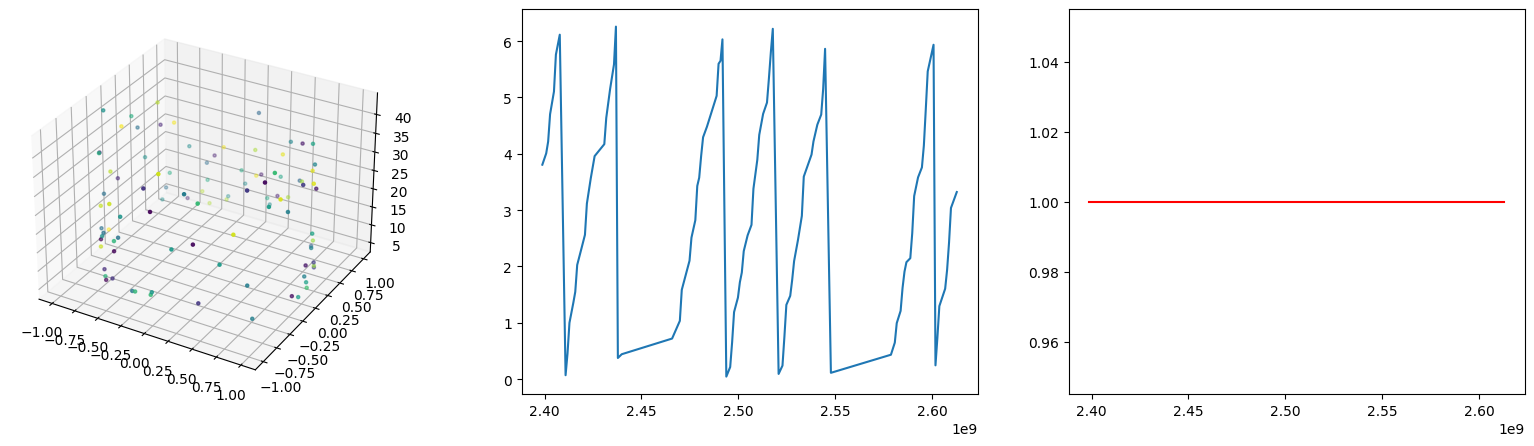

In [5]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
thetas = np.array(labels["angles"])
sort = np.argsort(thetas)
sorted_thetas = thetas[sort]
dataset = dataset_torch.detach().numpy()
sorted_dataset = dataset[sort, :]

times = labels["times"]
velocities = labels["velocities"]
gains = labels["gains"]
angles = np.radians(labels["angles"])
x = np.cos(angles)
y = np.sin(angles)

fig = plt.figure(figsize=(20, 5))

cyl = fig.add_subplot(1, 3, 1, projection="3d")

cyl.scatter3D(x, y, velocities, s=5, c=times)

prof = fig.add_subplot(1, 3, 2)

gain = fig.add_subplot(1, 3, 3)

prof.plot(times, angles)

gain.plot(times, gains, color="red");

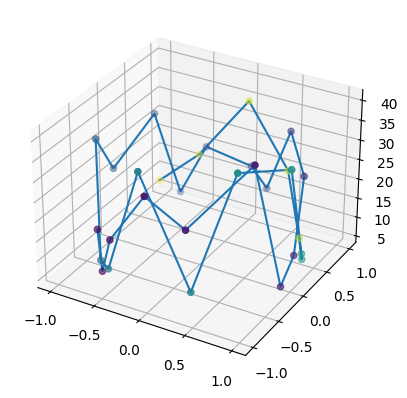

In [6]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")

T = 30

ax.plot3D(x[0:T], y[0:T], velocities[0:T])
ax.scatter3D(x[0:T], y[0:T], velocities[0:T], c=times[0:T])

# ax.plot3D(x, y, velocities)
# ax.scatter3D(x, y, velocities, c = times)

In [7]:
dataset_torch.shape

torch.Size([99, 12])

## Inspect from reconstruction

In [8]:
TRAINED_MODELS = os.path.join(os.getcwd(), "results/trained_models")
print(f"Available trained models in directory: {TRAINED_MODELS}")
for model_path in os.listdir(TRAINED_MODELS):
    print("-", model_path)

Available trained models in directory: /Volumes/GoogleDrive/My Drive/code/neurometry/neurometry/results/trained_models
- 2022-12-30 14:51:00_s1_synthetic_run_f6lf1kqb_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_moqyd9pq_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_zpuaxz74_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_9as5jt1n_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_pnxol6cm_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_yqj4d821_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_t6esqyz7_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_exe5ao7e_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_7161z7gq_model.pt
- 2022-12-30 14:51:00_s1_synthetic_run_rig5rbxv_model.pt
- 2022-12-30 14:51:00_experimental_41_gain_1_run_nnl6pw1z_model.pt
- 2022-12-30 14:51:00_experimental_41_gain_1_run_u91lhsuk_model.pt
- 2022-12-30 14:51:00_experimental_41_gain_1_run_k1q4zzp7_model.pt
- 2022-12-30 14:51:00_experimental_41_gain_1_run_nxnsx6xb_model.pt
- 2022-12-30 14:51:00_experimental_41_gain_

In [9]:
# Select a model that matches the config above
filename = os.path.join(
    TRAINED_MODELS, "2022-12-30 14:51:00_experimental_41_gain_1_run_ntjvi3kj_model.pt"
)

model = torch.load(filename)

In [10]:
z, _, _ = model(dataset_torch.to(config.device))

In [11]:
thetas = (torch.atan2(z[:, 1], z[:, 0]) + 2 * torch.pi) % (2 * torch.pi)

thetas = thetas.cpu().detach().cpu().numpy()
print(len(times))
print(len(thetas))

99
99


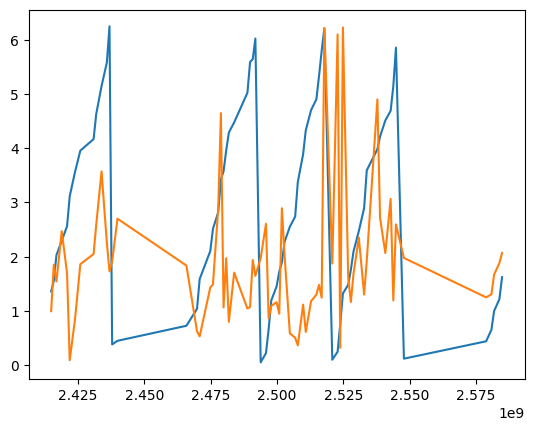

In [12]:
t1 = 10  # 1800
t2 = 80  # 1900
plt.plot(times[t1:t2], angles[t1:t2])
plt.plot(times[t1:t2], thetas[t1:t2]);

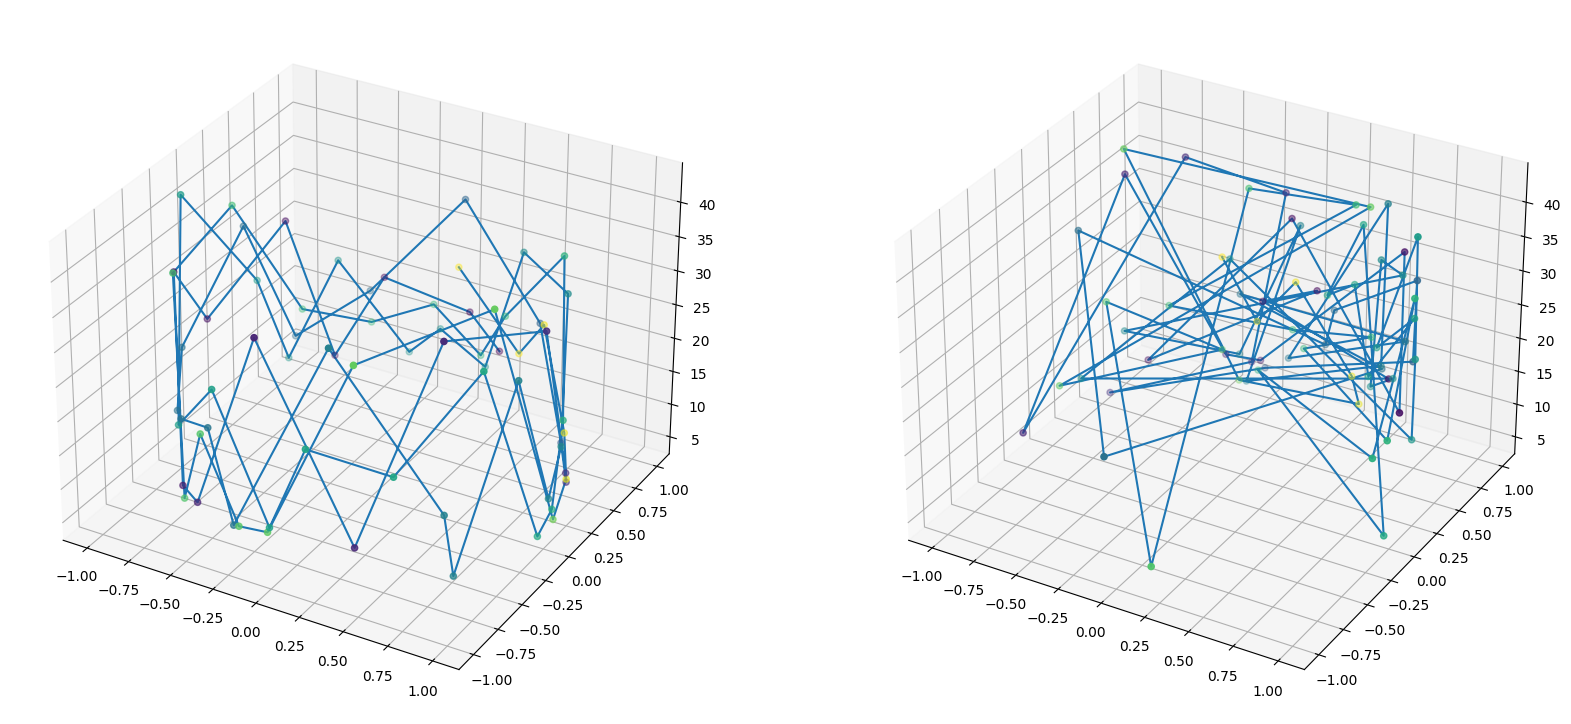

In [13]:
fig = plt.figure(figsize=(20, 10))

ax_true = fig.add_subplot(121, projection="3d")

ax_h = fig.add_subplot(122, projection="3d")


ax_true.plot3D(x[t1:t2], y[t1:t2], velocities[t1:t2])

ax_h.plot3D(np.cos(thetas)[t1:t2], np.sin(thetas)[t1:t2], velocities[t1:t2])

ax_true.scatter3D(x[t1:t2], y[t1:t2], velocities[t1:t2], c=times[t1:t2])

ax_h.scatter3D(
    np.cos(thetas)[t1:t2], np.sin(thetas)[t1:t2], velocities[t1:t2], c=times[t1:t2]
)

In [14]:
a = np.cumsum(angles)
th = np.cumsum(thetas)

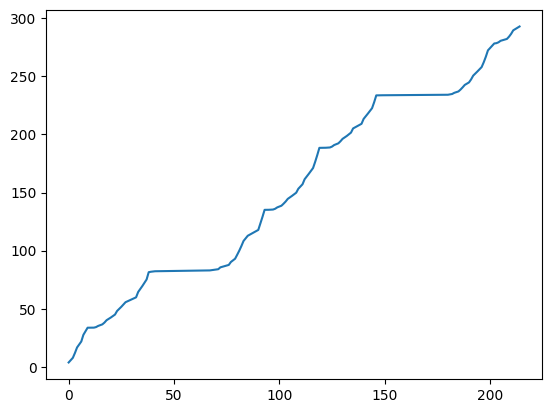

In [15]:
plt.plot(a);

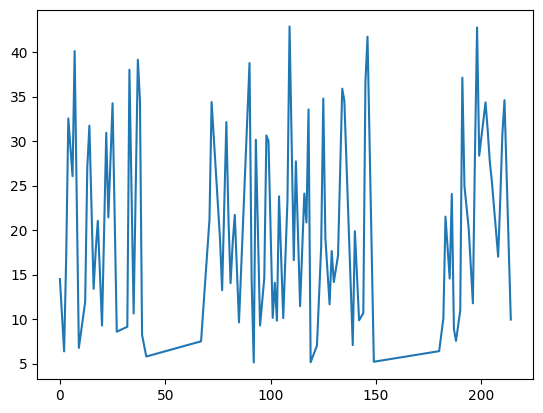

In [16]:
plt.plot(velocities)

In [17]:
a

0        3.806499
2        7.814594
3       12.031734
4       16.734583
6       21.839310
          ...    
208    282.131525
209    284.070198
210    286.492234
211    289.531074
214    292.852503
Name: angles, Length: 99, dtype: float64